In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# libraries
import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#### Reading Cancer data

In [2]:
import pickle
file = open("data_risk2_dummy","rb")
X_train = pickle.load(file)
y_train = pickle.load(file)
X_test = pickle.load(file)
y_test = pickle.load(file)
file.close()

In [3]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, classification_report

In [4]:
def model_stats(X, y, y_pred, model):

    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix ->")
    print(cm)

    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatives
    
    print("Accuracy:",accuracy_score(y, y_pred))

    sensi = TP / float(TP+FN)
    speci = TN / float(TN+FP)
    # Let's see the sensitivity of our model
    print("Sensitivity:", sensi)

    # Let us calculate specificity
    print("Specificity:", speci)

    print("Average:", (sensi+speci)/2)
    # Let us calculate precision
    print("Precision",TP / float(TP+FP))
    print("MCC ", metrics.matthews_corrcoef(y, y_pred))
    print("F1 ", metrics.fbeta_score(y, y_pred, beta = 1))
    print("F2 ", metrics.fbeta_score(y, y_pred, beta = 2))
    print("F3 ", metrics.fbeta_score(y, y_pred, beta = 3))
    
    print("Classification report")
    print(metrics.classification_report(y, y_pred))
    
    # Predicting probability for roc_auc
    pred_probs = model.predict_proba(X)[:,1]
    print("ROC-AUC : {:2.2}".format(roc_auc_score(y, pred_probs)))

    # Plotting ROC curve
    fpr, tpr, thresholds = roc_curve(y, pred_probs, drop_intermediate = False )
    auc_score = roc_auc_score(y, pred_probs)
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

## Model building on unsampled data with default parameters

In [5]:
### 2: Model Building

# Importing LogisticRegression and metrics from sklearn library
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [6]:
# Running Logistic Regression on default values
logreg = LogisticRegression()

logreg.fit(X_train,y_train)

LogisticRegression()

Confusion Matrix ->
[[109536      0]
 [  4293      0]]
Accuracy: 0.9622855335635031
Sensitivity: 0.0
Specificity: 1.0
Average: 0.5
Precision nan
MCC  0.0
F1  0.0
F2  0.0
F3  0.0
Classification report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    109536
           1       0.00      0.00      0.00      4293

    accuracy                           0.96    113829
   macro avg       0.48      0.50      0.49    113829
weighted avg       0.93      0.96      0.94    113829

ROC-AUC : 0.76


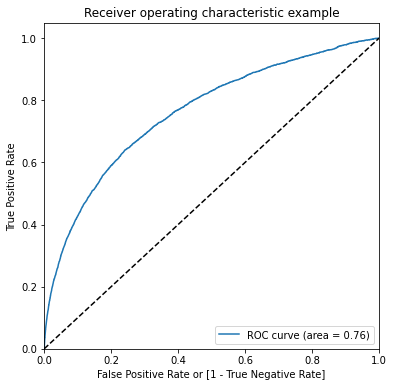

In [7]:
#predicting the train data
y_pred_train=logreg.predict(X_train)

model_stats(X_train, y_train, y_pred_train, logreg)

Confusion Matrix ->
[[57930     0]
 [ 1571     0]]
Accuracy: 0.9735970824019764
Sensitivity: 0.0
Specificity: 1.0
Average: 0.5
Precision nan
MCC  0.0
F1  0.0
F2  0.0
F3  0.0
Classification report
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     57930
           1       0.00      0.00      0.00      1571

    accuracy                           0.97     59501
   macro avg       0.49      0.50      0.49     59501
weighted avg       0.95      0.97      0.96     59501

ROC-AUC : 0.73


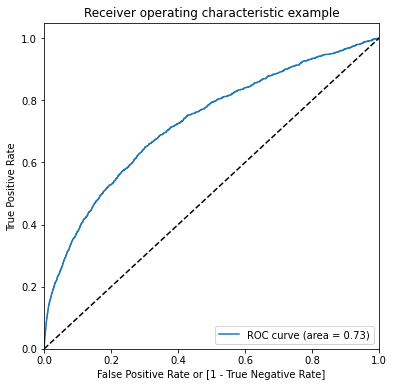

In [8]:
# predicting on the test data
y_pred_test=logreg.predict(X_test)

model_stats(X_test, y_test, y_pred_test, logreg)

In [9]:
### Building model using regularization and cross validation

# Create a cross validation scheme
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

In [10]:
### Building model using regularization and cross validation

# Specify range of hyper-parameters to tune
hyper_params = {'C': [10, 1, 0.5, 0.1]}

# Specify model for logistic regression with option to treat class imbalance and perform grid search
logreg = LogisticRegression(class_weight='balanced')

# GridSearchCV
model_cv = GridSearchCV(estimator = logreg,
                       param_grid = hyper_params,
                       scoring = "balanced_accuracy",
                       cv = folds,
                       verbose = 1,
                       return_train_score = True,
                       n_jobs=-1)

# Fit the model
model_cv.fit(X_train,y_train)

# printing the optimal accuracy score and hyperparameters
print("best balanced accuracy", model_cv.best_score_)
print("\n")
print(model_cv.best_estimator_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.6s finished


best balanced accuracy 0.6926882541622289


LogisticRegression(C=0.1, class_weight='balanced')


In [11]:
# It looks that C=0.5 is the best value

# Running Logistic Regression on Optimal hyperparameter value
logreg = LogisticRegression(C=0.1, class_weight='balanced')

logreg.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight='balanced')

# Coefficients
logreg.coef_

In [12]:
# List of cols with their coefficients
val=logreg.coef_.reshape(-1)
coef = (pd.DataFrame(val, index = X_train.columns, columns = ['coeff'] ))
coef = coef.sort_values(by = 'coeff', ascending=False)
coef

,coeff
agegrp_7,1.681085
agegrp_8,1.631887
agegrp_6,1.581674
agegrp_5,1.542797
agegrp_9,1.516431
agegrp_10,1.190423
agegrp_4,1.175888
agegrp_3,0.890081
agegrp_2,0.870407
hispanic_0,0.719290


In [13]:
y_pred_train=logreg.predict(X_train)

Confusion Matrix ->
[[74065 35471]
 [ 1240  3053]]
Accuracy: 0.67748991908916
Sensitivity: 0.7111576985790822
Specificity: 0.6761703914694712
Average: 0.6936640450242767
Precision 0.07924929913819956
MCC  0.15594098881941462
F1  0.14260690847093443
F2  0.2740771330077563
F3  0.3956662044296989
Classification report
              precision    recall  f1-score   support

           0       0.98      0.68      0.80    109536
           1       0.08      0.71      0.14      4293

    accuracy                           0.68    113829
   macro avg       0.53      0.69      0.47    113829
weighted avg       0.95      0.68      0.78    113829

ROC-AUC : 0.76


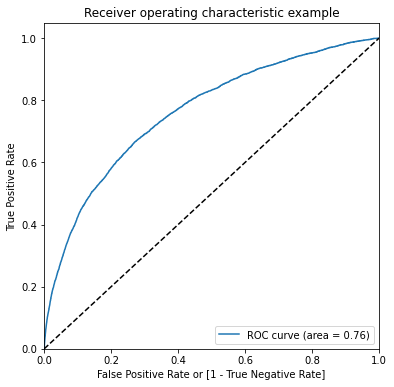

In [14]:
model_stats(X_train, y_train, y_pred_train, logreg)

Confusion Matrix ->
[[34472 23458]
 [  411  1160]]
Accuracy: 0.5988470782003664
Sensitivity: 0.7383831954169319
Specificity: 0.5950630070775074
Average: 0.6667231012472197
Precision 0.04711999350069055
MCC  0.10855062663351374
F1  0.08858681125663448
F2  0.1876901171445214
F3  0.2993007714735403
Classification report
              precision    recall  f1-score   support

           0       0.99      0.60      0.74     57930
           1       0.05      0.74      0.09      1571

    accuracy                           0.60     59501
   macro avg       0.52      0.67      0.42     59501
weighted avg       0.96      0.60      0.73     59501

ROC-AUC : 0.73


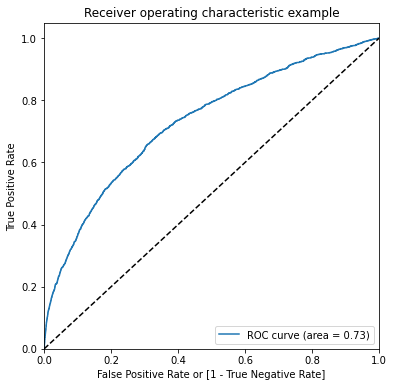

In [15]:
# Running Logistic Regression with class_weight parameter to handle class imbalance
y_pred_test=logreg.predict(X_test)

model_stats(X_test, y_test, y_pred_test, logreg)